# Regression in PyTorch

Use PyTorch's autodiff library to fit a straight line to data points.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
x = torch.tensor([0,1,2,3,4,5,6,7.]) # e.g. drug dosage for some disease
x

tensor([0., 1., 2., 3., 4., 5., 6., 7.])

In [3]:
x.shape

torch.Size([8])

Create some y values via linear equation ($y=mx+b$) with known model parameters ($m=-0.5$ and $b=2$) to check whether model learned these. Also add some random normally-distributed noise to simulate sampling error.

In [4]:
y = -0.5*x + 2 + torch.normal(mean=torch.zeros(8), std=0.2)
y # outcome we are measuring is the patients symptome intensity

tensor([ 1.6093,  1.2798,  1.0645,  0.4369,  0.1530, -0.4980, -1.1374, -1.5353])

In [5]:
torch.zeros(8) # create array of 8 zeros for the 8 x values to have errors around zero

tensor([0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
torch.normal(mean=torch.zeros(8), std=0.2) # std defines the amount of noise

tensor([-0.1929, -0.0065, -0.0474, -0.2109,  0.1790,  0.3450, -0.5187,  0.1663])

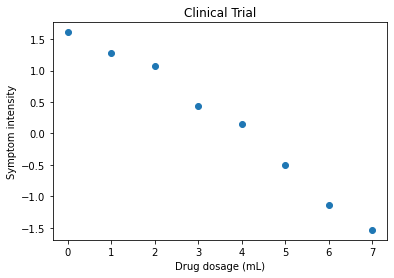

In [7]:
fig, ax = plt.subplots()
plt.title("Clinical Trial")
plt.xlabel("Drug dosage (mL)")
plt.ylabel("Symptom intensity")
ax.scatter(x, y)
plt.show()

This could be solved using linear algebra via the Moore-Penrose Pseudoinverse, but we will use a ML approach here using calculus, which allows us to differentiate and figure out how to fit a line through the data points.

We need to initialise our variables (i.e. parameters for the line) with some random near-zero values. Take $m=0.9$ and $b=0.4$ here.


(Note: In this simple demo, we could guess approximately-correct parameter values to start with. Or, we could use an algebraic (e.g., Moore-Penrose pseudoinverse) or statistical (e.g., ordinary-least-squares regression) to solve for the parameters quickly. This tiny machine learning demo with two parameters and eight data points scales, however, to millions of parameters and millions of data points. The other approaches -- guessing, algebra, statistics -- do not come close to scaling in this way.)

In [8]:
# set requires_grad to True
# so when we use our x values and flow them through a function
# any of the other tensors, that this "m" tensor comes in contact with will also track gradients
# allows for differentiation back from our outcome y
# enables to find the slope of y with respect to m and b
m = torch.tensor([0.9]).requires_grad_()
m

tensor([0.9000], requires_grad=True)

In [9]:
b = torch.tensor([0.4]).requires_grad_()
b

tensor([0.4000], requires_grad=True)

In [10]:
def regression(my_x, my_m, my_b):
  return my_m * my_x + my_b

In [11]:
def regression_plot(my_x, my_y, my_m, my_b):
    
    fig, ax = plt.subplots()

    ax.scatter(my_x, my_y)
    
    x_min, x_max = ax.get_xlim()
    y_min = regression(x_min, my_m, my_b)
    y_max = regression(x_max, my_m, my_b)
    
    ax.set_xlim([x_min, x_max])
    _ = ax.plot([x_min, x_max], [y_min, y_max])

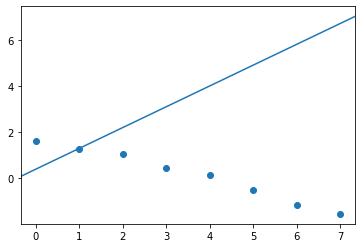

In [12]:
regression_plot(x, y, m, b)

## Machine Learning

### Step 1: Forward pass

- take input variables (here just one $x$)
- flow $x$ into regression model $y=mx+b$

In [13]:
y_hat = regression(x, m, b)
y_hat

tensor([0.4000, 1.3000, 2.2000, 3.1000, 4.0000, 4.9000, 5.8000, 6.7000],
       grad_fn=<AddBackward0>)

### Step 2: Calculate cost $C$ by comparison of $\hat{y}$ with true $y$

Mean Squared Error (MSE): $C(MSE) = \frac{1}{n} \sum_{i=1}^n (\hat{y_i}-y_i)^2 $

In [14]:
def mse(my_y_hat, my_y):
  mse_cost = (1/(len(my_y))) * torch.sum((my_y_hat - my_y)**2)
  return mse_cost

In [15]:
C = mse(y_hat, y)
C

tensor(21.2163, grad_fn=<MulBackward0>)

### Step 3: Use autodiff to calculate gradient of $C$ with respect to parameters $m$ and $b$

- $\frac{dC}{dm}>0$ means reducing m will reduce C, and vice versa
- $\frac{dC}{db}<0$ means increasing b will reduce C

In [16]:
# differentiate backwards from outermost tensor (cost)
# over y_hat, further backwards through regression function
# use chain rule & autodiff to calculate the slope of cost (C) with respect to weights (m) and intercept (b)
C.backward() 

In [17]:
m.grad # positive slope i.e. reduce m to reduce C

tensor([37.9826])

In [18]:
b.grad # positive slope i.e. reduce b to reduce C

tensor([6.7568])

### Step 4: Gradient descent

In [19]:
optimizer = torch.optim.SGD([m, b], lr=0.01)

In [20]:
optimizer.step() # this adjusts m and b i.e. changes them to reduce C

Confirm parameters have been adjusted sensibly

In [21]:
m

tensor([0.5202], requires_grad=True)

In [22]:
b

tensor([0.3324], requires_grad=True)

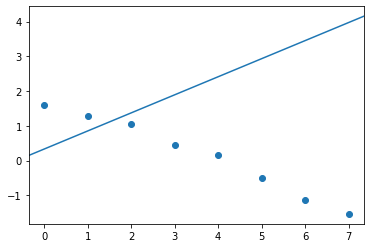

In [23]:
regression_plot(x, y, m, b)

Repeat steps 1 & 2 to confirm cost has decreased

In [24]:
C = mse(regression(x, m, b), y)
C

tensor(9.0419, grad_fn=<MulBackward0>)

### Iteratively minimise cost (MSE) toward zero

In [25]:
epochs = 1000 # train over entire dataset 1000 times

for epoch in range(epochs):
  optimizer.zero_grad() # reset gradients to zero, else they accumulate
  # Step 1: calculate y_hat using our regression model
  y_hat = regression(x, m, b)
  # Step 2: calculate cost using y_hat and y
  C = mse(y_hat, y) 
  # Step 3: use autodiff to calculate slope of cost w.r.t. parameters m & b
  C.backward() 
  # Step 4: adjust model parameters m & b by small step (lr=0.01) in direction told by slopes from step 3
  optimizer.step() 
  print("Epoch {}, Cost {}, m grad {}, b grad {}".format(
      epoch,
      "%.3g" % C.item(),
      "%.3g" % m.grad.item(),
      "%.3g" % b.grad.item()
  ))

Epoch 0, Cost 9.04, m grad 24.2, b grad 3.96
Epoch 1, Cost 4.12, m grad 15.5, b grad 2.19
Epoch 2, Cost 2.12, m grad 9.9, b grad 1.06
Epoch 3, Cost 1.31, m grad 6.36, b grad 0.348
Epoch 4, Cost 0.974, m grad 4.11, b grad -0.104
Epoch 5, Cost 0.835, m grad 2.68, b grad -0.389
Epoch 6, Cost 0.773, m grad 1.77, b grad -0.569
Epoch 7, Cost 0.743, m grad 1.19, b grad -0.681
Epoch 8, Cost 0.727, m grad 0.821, b grad -0.751
Epoch 9, Cost 0.715, m grad 0.586, b grad -0.793
Epoch 10, Cost 0.706, m grad 0.436, b grad -0.819
Epoch 11, Cost 0.697, m grad 0.341, b grad -0.833
Epoch 12, Cost 0.689, m grad 0.28, b grad -0.84
Epoch 13, Cost 0.681, m grad 0.241, b grad -0.843
Epoch 14, Cost 0.674, m grad 0.215, b grad -0.843
Epoch 15, Cost 0.666, m grad 0.199, b grad -0.841
Epoch 16, Cost 0.659, m grad 0.188, b grad -0.838
Epoch 17, Cost 0.651, m grad 0.181, b grad -0.835
Epoch 18, Cost 0.644, m grad 0.176, b grad -0.831
Epoch 19, Cost 0.637, m grad 0.173, b grad -0.826
Epoch 20, Cost 0.63, m grad 0.17

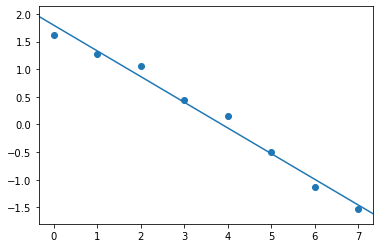

In [26]:
regression_plot(x, y, m, b)

In [27]:
m.item()

-0.4641123414039612

In [28]:
b.item()

1.7945642471313477

### Note

The model doesn't perfectly approximate the slope (-0.5) and $y$-intercept (2.0) used to simulate the outcomes $y$ at the top of this notebook. This reflects the imperfectness of the sample of eight data points due to adding random noise during the simulation step. In the real world, the best solution would be to sample additional data points: The more data we sample, the more accurate our estimates of the true underlying parameters will be.